# Pennylane QML assignment
- perform binary classification on the first two classes of the Iris dataset
- The Iris dataset contains three types of irises. We want to construct a classifier that can determine whether an Iris flower is Setosa or Versicolour based on its petal and sepal lengths
- Feature 0, Feature 2 -> Target = 0,1
- Code based on: https://pennylane.ai/qml/demos/tutorial_kernel_based_training/

In [1]:
# some imports
import numpy as np

import pandas as pd
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

np.random.seed(42)

## Fetch data

In [2]:
iris_data = load_iris()

In [3]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
print(iris_data)

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     

In [5]:
# convert from iris data to pandas
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['target'] = iris_data.target
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


## Cleanup data

In [6]:
# remove width columns
df.drop(columns=['sepal width (cm)', 'petal width (cm)'], inplace = True)

In [7]:
# remove class Virginica
df.drop(df.index[df['target'] == 2], inplace = True)

In [8]:
print(df.head())

   sepal length (cm)  petal length (cm)  target
0                5.1                1.4       0
1                4.9                1.4       0
2                4.7                1.3       0
3                4.6                1.5       0
4                5.0                1.4       0


## now get our test and training data-sets

In [9]:
X = df[['sepal length (cm)', 'petal length (cm)']]
y = df['target']

In [10]:
# scaling the inputs is important since the embedding we use is periodic (angles: 0... 2pi)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

## create and train model

In [11]:
n_qubits = len(X_train[0])
n_qubits

2

In [12]:
# 2 qubits are needed to encode to features
# we use angle encoding, this is used because:
# sepal length: 4.3...7.9
# petal length: 1.0...6.9
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

# kernel is the AngleEncoding(x1)*AngleEncoding(x2)^t
# if x1==x2 -> we get 0^n_qubits -> we use projection onto 0-plane as our metrics
# -> we need the expectation value of the hermitian 

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

In [13]:
# do sanity check -> if both are similar then we should obtain 0^n_qubits
kernel(X_train[0], X_train[0])

tensor(1., requires_grad=True)

In [14]:
# calculate gram matrix
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

In [15]:
# now lets train
svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)

## results

In [16]:
# now lets predict
predictions = svm.predict(X_test)

In [17]:
# now lets see the accuracy of our predictions
accuracy_score(predictions, y_test)

1.0

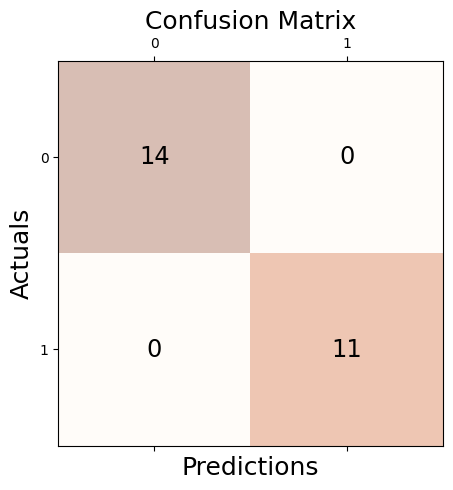

In [18]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()